In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import flower_dataset_C
from IPython import display

In [5]:
x_train,_=flower_dataset_C.get_data(format_size=112,normalize=True,convert=True)
x_train= x_train.astype('float32')

In [7]:
x_train = x_train[:780]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(28*28*256*1, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((28, 28,256*1)))
    model.add(layers.Conv2DTranspose(128*1, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64*1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1*1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

(1, 112, 112, 1)


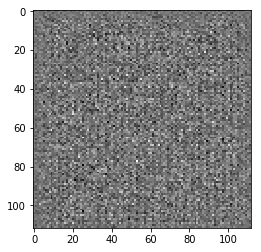

In [11]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image =generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0 ] * 127.5 + 127.5 , cmap='gray')

In [12]:
print(generated_image[0,:,:,0].shape)

(112, 112)


In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64*3, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[112, 112,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128*3, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00072651]], shape=(1, 1), dtype=float32)


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output,real_img,fake_img):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss + gradient_penalty(real_img,fake_img)

In [17]:
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [18]:
def gradient_penalty(x, x_gen):#real,fake
    try:
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        print("e+x")
        print(epsilon)
        print(x.shape)
        x_hat = epsilon * x + (1 - epsilon) * x_gen

        print("x_hat is")
        print(x_hat)

        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = discriminator(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    except:
        pass

In [19]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 100000
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        print(generated_images.shape)
        print(images.shape)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output,images,generated_images)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5 , cmap='gray')
        plt.axis('off')

    plt.show()

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

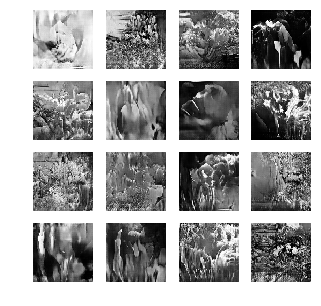

Time for epoch 18725 is 8.722295761108398 sec


In [ ]:
train(train_dataset,
      EPOCHS)